<center>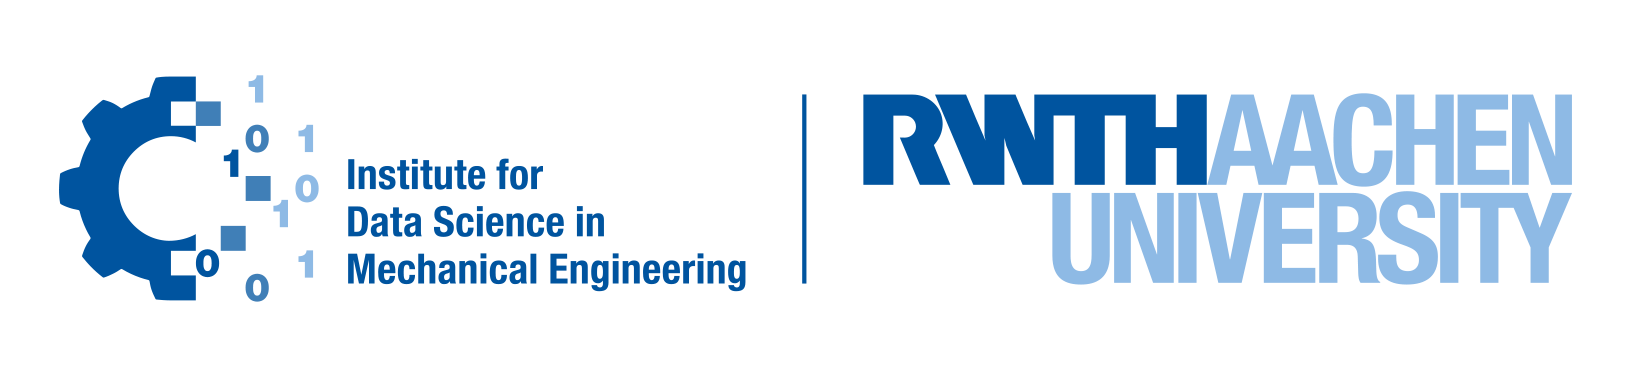</center>

**Reinforcement Learning and Learning-based Control** <br> 
RWTH Aachen University, DSME (Prof. Sebastian Trimpe) <br>

# Dynamic Programming in a Gridworld Example II
<center>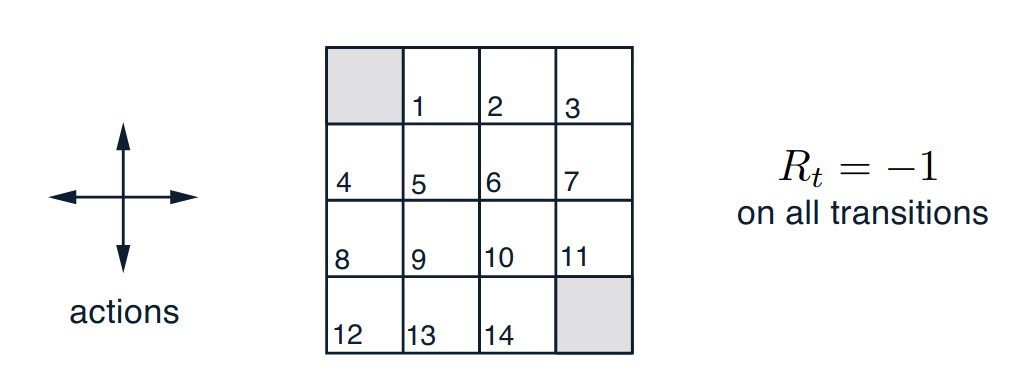</center>
(Example 4.1 in Sutton & Barto)

In [1]:
import numpy as np

In [2]:
class MDP:
    def __init__(self):
        self.num_states = 16
        self.num_actions = 4
        self.trans_prop = np.array([[0, "u", 0, 0, 1], [0, "d", 0, 0, 1], [0, "r", 0, 0, 1], [0, "l", 0, 0, 1],
                                    [1, "u", 1, -1, 1], [1, "d", 5, -1, 1], [1, "r", 2, -1, 1], [1, "l", 0, -1, 1],
                                    [2, "u", 2, -1, 1], [2, "d", 6, -1, 1], [2, "r", 3, -1, 1], [2, "l", 1, -1, 1],
                                    [3, "u", 3, -1, 1], [3, "d", 7, -1, 1], [3, "r", 3, -1, 1], [3, "l", 2, -1, 1],
                                    [4, "u", 0, -1, 1], [4, "d", 8, -1, 1], [4, "r", 5, -1, 1], [4, "l", 4, -1, 1],
                                    [5, "u", 1, -1, 1], [5, "d", 9, -1, 1], [5, "r", 6, -1, 1], [5, "l", 4, -1, 1],
                                    [6, "u", 2, -1, 1], [6, "d", 10, -1, 1], [6, "r", 7, -1, 1], [6, "l", 5, -1, 1],
                                    [7, "u", 3, -1, 1], [7, "d", 11, -1, 1], [7, "r", 7, -1, 1], [7, "l", 6, -1, 1],
                                    [8, "u", 4, -1, 1], [8, "d", 12, -1, 1], [8, "r", 9, -1, 1], [8, "l", 8, -1, 1],
                                    [9, "u", 5, -1, 1], [9, "d", 13, -1, 1], [9, "r", 10, -1, 1], [9, "l", 8, -1, 1],
                                    [10, "u", 6, -1, 1], [10, "d", 14, -1, 1], [10, "r", 11, -1, 1],
                                    [10, "l", 9, -1, 1],
                                    [11, "u", 7, -1, 1], [11, "d", 0, -1, 1], [11, "r", 11, -1, 1],
                                    [11, "l", 10, -1, 1],
                                    [12, "u", 8, -1, 1], [12, "d", 12, -1, 1], [12, "r", 13, -1, 1],
                                    [12, "l", 12, -1, 1],
                                    [13, "u", 9, -1, 1], [13, "d", 13, -1, 1], [13, "r", 14, -1, 1],
                                    [13, "l", 12, -1, 1],
                                    [14, "u", 10, -1, 1], [14, "d", 14, -1, 1], [14, "r", 0, -1, 1],
                                    [14, "l", 13, -1, 1],
                                    [15, "u", 15, 0, 1], [15, "d", 15, 0, 1], [15, "r", 15, 0, 1], [15, "l", 15, 0, 1]
                                    ])


class Agent:
    def __init__(self, num_states, num_actions, gamma=1.0):
        self.num_states = num_states
        self.num_actions = num_actions
        self.gamma = gamma
        self.old_policy = None
        self.policy = None
        self.old_value_function = None
        self.value_function = None
        self.reset_policy()
        self.reset_old_policy()
        self.reset_value_function()
        self.reset_old_value_function()

    def policy_evaluation(self, mdp):
        self.old_value_function = np.copy(self.value_function)

        for i in range(mdp.num_states):
            o1 = self.old_value_function[int(mdp.trans_prop[4 * i, 2]), 0]  # old values for state i
            o2 = self.old_value_function[int(mdp.trans_prop[4 * i + 1, 2]), 0]
            o3 = self.old_value_function[int(mdp.trans_prop[4 * i + 2, 2]), 0]
            o4 = self.old_value_function[int(mdp.trans_prop[4 * i + 3, 2]), 0]

            r1 = float(mdp.trans_prop[4 * i + 0, 3])  # rewards for action a in state s
            r2 = float(mdp.trans_prop[4 * i + 1, 3])
            r3 = float(mdp.trans_prop[4 * i + 2, 3])
            r4 = float(mdp.trans_prop[4 * i + 3, 3])
            # As the mdp we consider here is deterministic, the sum over subsequent states and rewards only consists of one element
            self.value_function[i] = self.policy[i, 0] * float(mdp.trans_prop[4 * i + 0, 4]) * (r1 + self.gamma * o1) + \
                                     self.policy[i, 1] * float(mdp.trans_prop[4 * i + 1, 4]) * (r2 + self.gamma * o2) + \
                                     self.policy[i, 2] * float(mdp.trans_prop[4 * i + 2, 4]) * (r3 + self.gamma * o3) + \
                                     self.policy[i, 3] * float(mdp.trans_prop[4 * i + 3, 4]) * (r4 + self.gamma * o4)

    def policy_evaluation_ipu(self, mdp):
        self.old_value_function = np.copy(self.value_function)
        '''
        We only keep the second value function to reuse the convergence cirterion for stopping as in the case with two value functions.
        However this value function is not required in the algorithm and could be omitted likewise.
        '''
        for i in range(mdp.num_states):
            o1 = self.value_function[int(mdp.trans_prop[4 * i, 2]), 0]  # old values for state i
            o2 = self.value_function[int(mdp.trans_prop[4 * i + 1, 2]), 0]
            o3 = self.value_function[int(mdp.trans_prop[4 * i + 2, 2]), 0]
            o4 = self.value_function[int(mdp.trans_prop[4 * i + 3, 2]), 0]

            r1 = float(mdp.trans_prop[4 * i + 0, 3])  # rewards for action a in state s
            r2 = float(mdp.trans_prop[4 * i + 1, 3])
            r3 = float(mdp.trans_prop[4 * i + 2, 3])
            r4 = float(mdp.trans_prop[4 * i + 3, 3])
            # As the mdp we consider here is deterministic, the sum over subsequent states and rewards only consists of one element
            self.value_function[i] = self.policy[i, 0] * float(mdp.trans_prop[4 * i + 0, 4]) * (r1 + self.gamma * o1) + \
                                     self.policy[i, 1] * float(mdp.trans_prop[4 * i + 1, 4]) * (r2 + self.gamma * o2) + \
                                     self.policy[i, 2] * float(mdp.trans_prop[4 * i + 2, 4]) * (r3 + self.gamma * o3) + \
                                     self.policy[i, 3] * float(mdp.trans_prop[4 * i + 3, 4]) * (r4 + self.gamma * o4)

    def value_iteration(self, mdp):
        self.old_value_function = np.copy(self.value_function)

        for i in range(mdp.num_states):
            o1 = self.old_value_function[int(mdp.trans_prop[4 * i, 2]), 0]  # old values for state i
            o2 = self.old_value_function[int(mdp.trans_prop[4 * i + 1, 2]), 0]
            o3 = self.old_value_function[int(mdp.trans_prop[4 * i + 2, 2]), 0]
            o4 = self.old_value_function[int(mdp.trans_prop[4 * i + 3, 2]), 0]

            r1 = float(mdp.trans_prop[4 * i + 0, 3])  # rewards for action a in state s
            r2 = float(mdp.trans_prop[4 * i + 1, 3])
            r3 = float(mdp.trans_prop[4 * i + 2, 3])
            r4 = float(mdp.trans_prop[4 * i + 3, 3])
            # As the mdp we consider here is deterministic, the sum over subsequent states and rewards only consists of one element
            self.value_function[i] = np.max(np.array([float(mdp.trans_prop[4 * i + 0, 4]) * (r1 + self.gamma * o1), float(mdp.trans_prop[4 * i + 1, 4]) * (r2 + self.gamma * o2) , float(mdp.trans_prop[4 * i + 2, 4]) * (r3 + self.gamma * o3), float(mdp.trans_prop[4 * i + 3, 4]) * (r4 + self.gamma * o4)]))

    def value_iteration_ipu(self, mdp):
        self.old_value_function = np.copy(self.value_function)

        for i in range(mdp.num_states):
            o1 = self.value_function[int(mdp.trans_prop[4 * i, 2]), 0]  # old values for state i
            o2 = self.value_function[int(mdp.trans_prop[4 * i + 1, 2]), 0]
            o3 = self.value_function[int(mdp.trans_prop[4 * i + 2, 2]), 0]
            o4 = self.value_function[int(mdp.trans_prop[4 * i + 3, 2]), 0]

            r1 = float(mdp.trans_prop[4 * i + 0, 3])  # rewards for action a in state s
            r2 = float(mdp.trans_prop[4 * i + 1, 3])
            r3 = float(mdp.trans_prop[4 * i + 2, 3])
            r4 = float(mdp.trans_prop[4 * i + 3, 3])
            # As the mdp we consider here is deterministic, the sum over subsequent states and rewards only consists of one element
            self.value_function[i] = np.max(np.array([float(mdp.trans_prop[4 * i + 0, 4]) * (r1 + self.gamma * o1), float(mdp.trans_prop[4 * i + 1, 4]) * (r2 + self.gamma * o2) , float(mdp.trans_prop[4 * i + 2, 4]) * (r3 + self.gamma * o3), float(mdp.trans_prop[4 * i + 3, 4]) * (r4 + self.gamma * o4)]))

    def policy_improvement(self, mdp):
        self.old_policy = np.copy(self.policy)
        values = np.copy(self.value_function)

        for i in range(1, 15):
            neighborValues = [0, 0, 0, 0]
            neighbors = mdp.trans_prop[i * 4:i * 4 + 4:1, 2]
            for j in range(4):
                neighborValues[j] = float(mdp.trans_prop[i * 4 + j, 3]) + self.gamma * float(values[int(neighbors[j])])

            policyValues = np.flatnonzero(neighborValues == np.max(neighborValues))
            for k in range(self.num_actions):
                if k in policyValues:
                    self.policy[i, k] = 1 / len(policyValues)
                else:
                    self.policy[i, k] = 0

    def render_value_function(self):
        test = False
        if abs(np.min(self.value_function)) > 10:
            test = True
        if test:
            print('-------------------------------------')
        else:
            print('---------------------------------')
        out = '| '
        for i in range(16):
            token = float(np.round(self.value_function[i], 2))
            convertedToken = "{:.2f}".format(token)
            if token == 0:
                out += " "
            if test and token > -10:
                out += " "
            out += str(convertedToken) + ' | '
            if (i + 1) % 4 == 0:
                print(out)
                if test:
                    print('-------------------------------------')
                else:
                    print('---------------------------------')
                out = '| '

    def render_policy(self):
        pol = np.copy(self.policy)
        print('-----------------------------')
        out = '| '
        for i in range(self.num_states):
            token = ""
            if pol[i, 3] > 0:  # left
                token += "\u2190"
            if pol[i, 0] > 0:  # up
                token += "\u2191"
            if pol[i, 1] > 0:  # down
                token += "\u2193"
            if pol[i, 2] > 0:  # right
                token += "\u2192"
            if token == "":  # empty
                token += "  "

            if len(token) == 1:
                token += '  '
                token = ' ' + token
            elif len(token) == 2:
                token += ' '
                token = ' ' + token
            elif len(token) == 3:
                token += ' '

            out += token + ' | '
            if (i + 1) % 4 == 0:
                print(out)
                print('-----------------------------')
                out = '| '

    def reset_value_function(self):
        self.value_function = np.zeros((self.num_states, 1))

    def reset_old_value_function(self):
        self.old_value_function = np.ones((self.num_states, 1)) * 1e9

    def reset_policy(self):
        self.policy = np.ones((self.num_states, self.num_actions)) * (1.0 / self.num_actions)
        self.policy[0, :] = 0
        self.policy[-1, :] = 0

    def reset_old_policy(self):
        self.old_policy = np.zeros((self.num_states, self.num_actions))

In [3]:
mdp = MDP()
agent = Agent(num_states=mdp.num_states, num_actions=mdp.num_actions)

## Policy Iteration

In [4]:
print('*************************************************************************************')
print('Initial setup')
print('*************************************************************************************')
print('Value Function:')
agent.render_value_function()
print('Policy:')
agent.render_policy()
policy_stable = False
threshold = 0.01
j = 0
while not policy_stable:
    j += 1
    print('*************************************************************************************')
    print('Iteration ' + str(j))
    print('*************************************************************************************')
    i = 0
    while True:
        agent.policy_evaluation(mdp=mdp)
        i += 1
        if np.max(np.abs(agent.old_value_function - agent.value_function)) < threshold:
            break
    print(f'Policy evaluation converged after {i} iterations.')
    print('Value Function:')
    agent.render_value_function()

    agent.policy_improvement(mdp=mdp)

    if np.max(np.abs(agent.old_policy - agent.policy)) == 0:
        policy_stable = True
    print('Policy:')
    agent.render_policy()

agent.reset_value_function()
agent.reset_old_value_function()
agent.reset_policy()
agent.reset_old_policy()

*************************************************************************************
Initial setup
*************************************************************************************
Value Function:
---------------------------------
|  0.00 |  0.00 |  0.00 |  0.00 | 
---------------------------------
|  0.00 |  0.00 |  0.00 |  0.00 | 
---------------------------------
|  0.00 |  0.00 |  0.00 |  0.00 | 
---------------------------------
|  0.00 |  0.00 |  0.00 |  0.00 | 
---------------------------------
Policy:
-----------------------------
|      | ←↑↓→ | ←↑↓→ | ←↑↓→ | 
-----------------------------
| ←↑↓→ | ←↑↓→ | ←↑↓→ | ←↑↓→ | 
-----------------------------
| ←↑↓→ | ←↑↓→ | ←↑↓→ | ←↑↓→ | 
-----------------------------
| ←↑↓→ | ←↑↓→ | ←↑↓→ |      | 
-----------------------------
*************************************************************************************
Iteration 1
*************************************************************************************
Policy evaluation conv

## Policy Iteration with in-place updates

In [5]:
print('*************************************************************************************')
print('Initial setup')
print('*************************************************************************************')
print('Value Function:')
agent.render_value_function()
print('Policy:')
agent.render_policy()
policy_stable = False
threshold = 0.01
j = 0
while not policy_stable:
    j += 1
    print('*************************************************************************************')
    print('Iteration ' + str(j))
    print('*************************************************************************************')
    i = 0
    while True:
        agent.policy_evaluation_ipu(mdp=mdp)
        i += 1
        if np.max(np.abs(agent.old_value_function - agent.value_function)) < threshold:
            break
    print(f'Policy evaluation converged after {i} iterations.')
    print('Value Function:')
    agent.render_value_function()

    agent.policy_improvement(mdp=mdp)

    if np.max(np.abs(agent.old_policy - agent.policy)) == 0:
        policy_stable = True
    print('Policy:')
    agent.render_policy()

agent.reset_value_function()
agent.reset_old_value_function()
agent.reset_policy()
agent.reset_old_policy()

*************************************************************************************
Initial setup
*************************************************************************************
Value Function:
---------------------------------
|  0.00 |  0.00 |  0.00 |  0.00 | 
---------------------------------
|  0.00 |  0.00 |  0.00 |  0.00 | 
---------------------------------
|  0.00 |  0.00 |  0.00 |  0.00 | 
---------------------------------
|  0.00 |  0.00 |  0.00 |  0.00 | 
---------------------------------
Policy:
-----------------------------
|      | ←↑↓→ | ←↑↓→ | ←↑↓→ | 
-----------------------------
| ←↑↓→ | ←↑↓→ | ←↑↓→ | ←↑↓→ | 
-----------------------------
| ←↑↓→ | ←↑↓→ | ←↑↓→ | ←↑↓→ | 
-----------------------------
| ←↑↓→ | ←↑↓→ | ←↑↓→ |      | 
-----------------------------
*************************************************************************************
Iteration 1
*************************************************************************************
Policy evaluation conv

## Value Iteration

In [6]:
print('*************************************************************************************')
print('Initial setup')
print('*************************************************************************************')
print('Value Function:')
agent.render_value_function()
print('Policy:')
agent.render_policy()

threshold = 0.01
i = 0
while True:
    agent.value_iteration(mdp=mdp)
    i += 1
    if np.max(np.abs(agent.old_value_function - agent.value_function)) < threshold:
        break
print(f'Value iteration converged after {i} iterations.')
print('Value Function:')
agent.render_value_function()
'''
This policy improvement step is not required by the algorithm.
We just do it to update our policy matrix so we can plot the policy nicely.
'''
agent.policy_improvement(mdp=mdp)
print('Policy:')
agent.render_policy()

agent.reset_value_function()
agent.reset_old_value_function()
agent.reset_policy()
agent.reset_old_policy()

*************************************************************************************
Initial setup
*************************************************************************************
Value Function:
---------------------------------
|  0.00 |  0.00 |  0.00 |  0.00 | 
---------------------------------
|  0.00 |  0.00 |  0.00 |  0.00 | 
---------------------------------
|  0.00 |  0.00 |  0.00 |  0.00 | 
---------------------------------
|  0.00 |  0.00 |  0.00 |  0.00 | 
---------------------------------
Policy:
-----------------------------
|      | ←↑↓→ | ←↑↓→ | ←↑↓→ | 
-----------------------------
| ←↑↓→ | ←↑↓→ | ←↑↓→ | ←↑↓→ | 
-----------------------------
| ←↑↓→ | ←↑↓→ | ←↑↓→ | ←↑↓→ | 
-----------------------------
| ←↑↓→ | ←↑↓→ | ←↑↓→ |      | 
-----------------------------
Value iteration converged after 4 iterations.
Value Function:
---------------------------------
|  0.00 | -1.00 | -2.00 | -3.00 | 
---------------------------------
| -1.00 | -2.00 | -3.00 | -2.00 | 
------

## Value Iteration with in-place updates

In [7]:
print('*************************************************************************************')
print('Initial setup')
print('*************************************************************************************')
print('Value Function:')
agent.render_value_function()
print('Policy:')
agent.render_policy()

threshold = 0.01
i = 0
while True:
    agent.value_iteration(mdp=mdp)
    i += 1
    if np.max(np.abs(agent.old_value_function - agent.value_function)) < threshold:
        break
print(f'Value iteration converged after {i} iterations.')
print('Value Function:')
agent.render_value_function()
'''
This policy improvement step is not required by the algorithm.
We just do it to update our policy matrix so we can plot the policy nicely.
'''
agent.policy_improvement(mdp=mdp)
print('Policy:')
agent.render_policy()

agent.reset_value_function()
agent.reset_old_value_function()
agent.reset_policy()
agent.reset_old_policy()

*************************************************************************************
Initial setup
*************************************************************************************
Value Function:
---------------------------------
|  0.00 |  0.00 |  0.00 |  0.00 | 
---------------------------------
|  0.00 |  0.00 |  0.00 |  0.00 | 
---------------------------------
|  0.00 |  0.00 |  0.00 |  0.00 | 
---------------------------------
|  0.00 |  0.00 |  0.00 |  0.00 | 
---------------------------------
Policy:
-----------------------------
|      | ←↑↓→ | ←↑↓→ | ←↑↓→ | 
-----------------------------
| ←↑↓→ | ←↑↓→ | ←↑↓→ | ←↑↓→ | 
-----------------------------
| ←↑↓→ | ←↑↓→ | ←↑↓→ | ←↑↓→ | 
-----------------------------
| ←↑↓→ | ←↑↓→ | ←↑↓→ |      | 
-----------------------------
Value iteration converged after 4 iterations.
Value Function:
---------------------------------
|  0.00 | -1.00 | -2.00 | -3.00 | 
---------------------------------
| -1.00 | -2.00 | -3.00 | -2.00 | 
------